In [24]:
import pandas as pd
import re
from langdetect import detect

In [ ]:
df = pd.read_csv("data/data_ma.csv")

df_filtered = df[-df['text'].isna()].drop_duplicates(
        subset='text', 
        keep='first'
        # The reviews match data/reviews.json
    )[['user_id', 'gmap_id', 'text', 'rating']]

In [21]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

english_mask = df['text'].apply(is_english)

In [23]:
df_filtered = df_filtered[english_mask]
df_filtered.to_csv("data/english_reviews.csv", index=False)

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_74468/3195401655.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[english_mask]


In [124]:
df_filtered = pd.read_csv("data/english_reviews.csv")

In [36]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+", flags=re.UNICODE)

In [49]:
has_emoji = df_filtered.text.apply(lambda x: bool(emoji_pattern.search(x)))
df_filtered[has_emoji].text.count()

0

In [47]:
df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_74468/3423525240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))


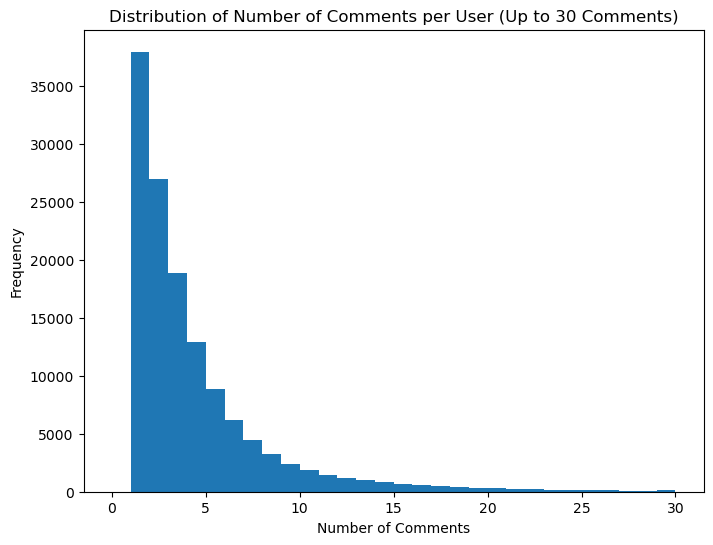

In [71]:
comment_counts = df_filtered['user_id'].value_counts()
threshold = 30

# Plotting the distribution of comment counts, but only up to 50 comments
plt.figure(figsize=(8, 6))
comment_counts[comment_counts <= threshold].hist(bins=threshold, range=(0,threshold))
plt.title(f'Distribution of Number of Comments per User (Up to {threshold} Comments)')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


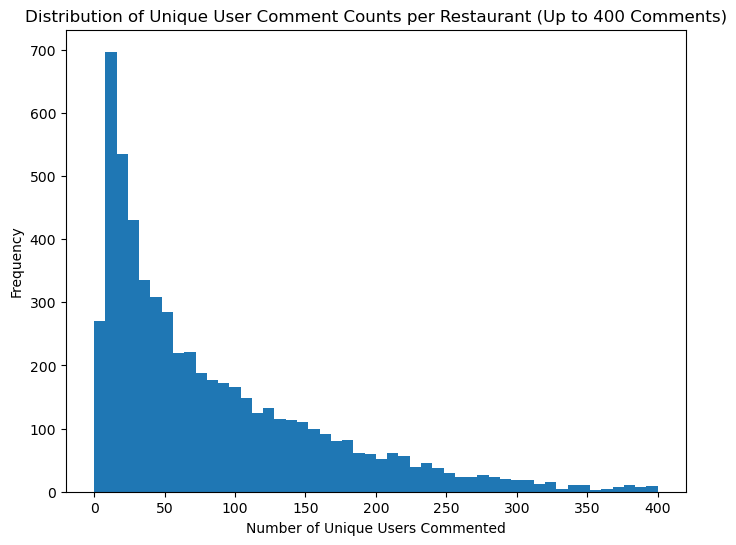

In [70]:
restaurant_user_counts = df_filtered.groupby('gmap_id')['user_id'].nunique()

plt.figure(figsize=(8, 6))
restaurant_user_counts[restaurant_user_counts <= 400].hist(bins=50, range=(0, 400))
plt.title('Distribution of Unique User Comment Counts per Restaurant (Up to 400 Comments)')
plt.xlabel('Number of Unique Users Commented')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [125]:
# Filter to include only those user_ids with more than 15 comments
users_with_more_threshold = comment_counts[comment_counts >= 10].index
df_filtered = df_filtered[df_filtered['user_id'].isin(users_with_more_threshold)]

In [126]:
# Replace '\n' or whitespaces with a white space ' '
df_filtered['text'] = df_filtered['text'].str.replace('\s+', ' ', regex=True)
concatenated_comments = df_filtered.groupby('user_id')['text'].apply(lambda x: '\n'.join(x))

In [127]:
concatenated_comments

user_id
1.000018e+20    Great food. The service was a little slow. It ...
1.000020e+20    I like the variety of burgers they offer. But ...
1.000027e+20    Margarita was yummy. Food not great.\nCrazy No...
1.000030e+20    Very good food a little pricey but worth every...
1.000057e+20    Delightful and charming place to dine outside....
                                      ...                        
1.184382e+20    Nice little place in Sudbury.Good prices and g...
1.184401e+20    Over the phone order takes forever.\nReception...
1.184433e+20    Was great food and service\nA little pricey fo...
1.184449e+20    Only came because we had a gift card. Reminded...
1.184461e+20    Good for beach food.\nKaren is the best waitre...
Name: text, Length: 10985, dtype: object

In [128]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(concatenated_comments,
                                     test_size=0.3, random_state=209)

In [135]:
train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=True)
test_df.to_csv('data/user_concat_text_10_test.csv', sep=';', index=True)
